### Compare models in SVD, PMF and Logistic PMF


In [1]:
from recom.datasets import load_ml_small_rating

# load data
dataset = load_ml_small_rating(need_raw=True)

# load features
ratings = dataset['raw']
ratings_train_dict = dataset['train_dict']
ratings_test_dict = dataset['test_dict']
n_user = dataset['n_user']
n_item = dataset['n_item']
user2ix = dataset['user2ix']
ix2user = dataset['ix2user']
item2ix = dataset['item2ix']
ix2item = dataset['ix2item']

del dataset

print(f'Users: {n_user}, Items: {n_item}. Sparsity: {round(1-len(ratings)/n_user/n_item, 4)}')
print(f'User reduced from {len(user2ix.keys())} to {len(ratings_train_dict.keys())}')

Users: 610, Items: 9724. Sparsity: 0.983
User reduced from 610 to 607


In [11]:
from recom.model.MF import FunkSvd, PMF, LogisticPMF
from torch import optim
import warnings
warnings.filterwarnings("ignore")

k_dim = 32
n_epochs = 256
use_cuda = True
report_interval = 32
user_per_ep = 128
item_per_ep = 128

""" 1. FunkSVD """
# init model
fsvd = FunkSvd(
    n_user=n_user
    , n_item=n_item
    , k_dim=k_dim
)
# define optimizer
opt = optim.SGD(fsvd.parameters(), lr=1, weight_decay=0.01, momentum=0.01)
# train model on gpu, with data and optimizer
fsvd.fit(ratings_train_dict, opt, user_per_ep=user_per_ep, item_per_ep=item_per_ep, n_epochs=n_epochs, use_cuda=use_cuda, report_interval=report_interval)
# return model to cpu
fsvd = fsvd.to('cpu')


""" 2. PMF """
# init model
pmf = PMF(
    n_user=n_user
    , n_item=n_item
    , k_dim=k_dim
    , std_user=1
    , std_item=1
)
# define optimizer
opt = optim.SGD(pmf.parameters(), lr=1, weight_decay=0.01, momentum=0.01)
# train model on gpu, with data and optimizer
pmf.fit(ratings_train_dict, opt, user_per_ep=user_per_ep, item_per_ep=item_per_ep, n_epochs=n_epochs, use_cuda=use_cuda, report_interval=report_interval)
# return model to cpu
pmf = pmf.to('cpu')


""" 3. LogisticPMF """
# init model
lpmf = LogisticPMF(
    n_user=n_user
    , n_item=n_item
    , k_dim=k_dim
    , std_user=1
    , std_item=1
)
# define optimizer
opt = optim.SGD(lpmf.parameters(), lr=1, weight_decay=0.01, momentum=0.01)
# train model on gpu, with data and optimizer
lpmf.fit(ratings_train_dict, opt, user_per_ep=user_per_ep, item_per_ep=item_per_ep, n_epochs=n_epochs, use_cuda=use_cuda, report_interval=report_interval)
# return model to cpu
lpmf = lpmf.to('cpu')


from recom.eval.evaluator import generate_testing_candidates

# init testing candidates
cand_test = generate_testing_candidates(ratings_train_dict, ix2item)

# predict result
fsvd_pred_results = fsvd.pred_on_candidate_dict(cand_test)
pmf_pred_results = pmf.pred_on_candidate_dict(cand_test)
lpmf_pred_results = lpmf.pred_on_candidate_dict(cand_test)

Epoch: 32, Time: 9.32, /Average loss 7.16129
Epoch: 64, Time: 9.23, /Average loss 7.02188
Epoch: 96, Time: 8.26, /Average loss 7.62493
Epoch: 128, Time: 8.23, /Average loss 6.99707
Epoch: 160, Time: 8.32, /Average loss 6.74318
Epoch: 192, Time: 8.39, /Average loss 6.89962
Epoch: 224, Time: 8.29, /Average loss 6.78799
Epoch: 256, Time: 8.19, /Average loss 7.93444
Epoch: 32, Time: 8.37, /Average loss 7.1463
Epoch: 64, Time: 8.24, /Average loss 7.01238
Epoch: 96, Time: 8.42, /Average loss 6.89
Epoch: 128, Time: 8.32, /Average loss 6.94877
Epoch: 160, Time: 8.39, /Average loss 7.16419
Epoch: 192, Time: 8.25, /Average loss 7.43543
Epoch: 224, Time: 8.39, /Average loss 7.14703
Epoch: 256, Time: 8.29, /Average loss 7.10148
Epoch: 32, Time: 8.51, /Average loss 0.09601
Epoch: 64, Time: 10.96, /Average loss 0.09726
Epoch: 96, Time: 60.56, /Average loss 0.09936
Epoch: 128, Time: 8.55, /Average loss 0.10157
Epoch: 160, Time: 8.59, /Average loss 0.09778
Epoch: 192, Time: 8.57, /Average loss 0.09781

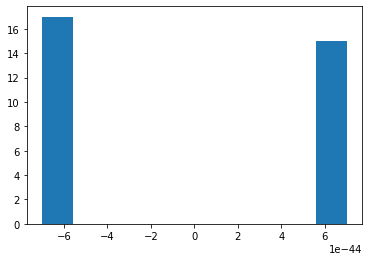

In [13]:
import matplotlib.pyplot as plt

plt.hist(lpmf.embedding_user(LongTensor([0])).detach().numpy()[0])
plt.show()

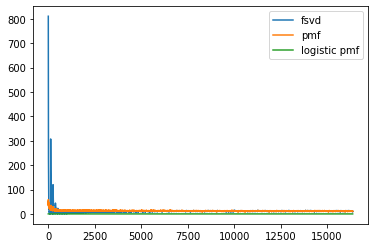

In [9]:
loss_fsvd = fsvd.last_train_loss
loss_pmf = pmf.last_train_loss
loss_lpmf = lpmf.last_train_loss

import matplotlib.pyplot as plt

plt.plot(list(range(len(loss_fsvd))), loss_fsvd)
plt.plot(list(range(len(loss_pmf))), loss_pmf)
plt.plot(list(range(len(loss_lpmf))), loss_lpmf)

plt.legend(['fsvd', 'pmf', 'logistic pmf'])
plt.show()

(0.0, 0.19769357495881384, 0.31795716639209226, 0.3904448105436573, 0.44810543657331137, 0.49917627677100496, 0.5321252059308073, 0.5601317957166392, 0.586490939044481, 0.6161449752883031, 0.6342668863261944, 0.6507413509060955, 0.6639209225700164, 0.6738056013179572, 0.685337726523888)
(0.0, 0.23393739703459637, 0.3525535420098847, 0.4514003294892916, 0.4958813838550247, 0.5304777594728172, 0.5420098846787479, 0.5584843492586491, 0.5700164744645799, 0.5831960461285008, 0.6029654036243822, 0.6194398682042833, 0.6326194398682042, 0.6457990115321252, 0.6507413509060955)
(0.0, 0.09884678747940692, 0.11367380560131796, 0.13673805601317957, 0.15815485996705106, 0.17792421746293247, 0.19439868204283361, 0.2026359143327842, 0.214168039538715, 0.22405271828665568, 0.24217462932454695, 0.2487644151565074, 0.25370675453047775, 0.2553542009884679, 0.26194398682042835) 

(0.0, 0.19769357495881384, 0.3328185633678564, 0.4193095024123374, 0.4817469605844282, 0.546116208575679, 0.5942364546100409, 0.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 0.021914550521996753, 0.03987611809576669, 0.05107736558038409, 0.057900121581054384, 0.06665070079399216, 0.07146964402831929, 0.0747641050838618, 0.07670292827644241, 0.08020570887886352, 0.08216123730423519, 0.08381547353188701, 0.08520176412428472, 0.0864510707810037, 0.08753992639984325)
(0.0, 0.022785892681354253, 0.03939395423721764, 0.05625614982385219, 0.0620042853638235, 0.0662323602035697, 0.06692899218506757, 0.06715881730859424, 0.06905482259965595, 0.07062018009165356, 0.07362580681821122, 0.07508580719115415, 0.07713604058404827, 0.07820602277627485, 0.07931516507829135)
(0.0, 0.009836430773967394, 0.010665252228580613, 0.011817906149444444, 0.012631671518389904, 0.013619977458771302, 0.014369698682894927, 0.01461225184151722, 0.014778665532962752, 0.014773603303069895, 0.01572794346358932, 0.015505678938740207, 0.015351159023708504, 0.014846491187775444, 0.014728375672131202) 

(0.0, 0.19769357495881384, 0.1758649093904448, 0.1534870950027459, 0.13354612850082373,

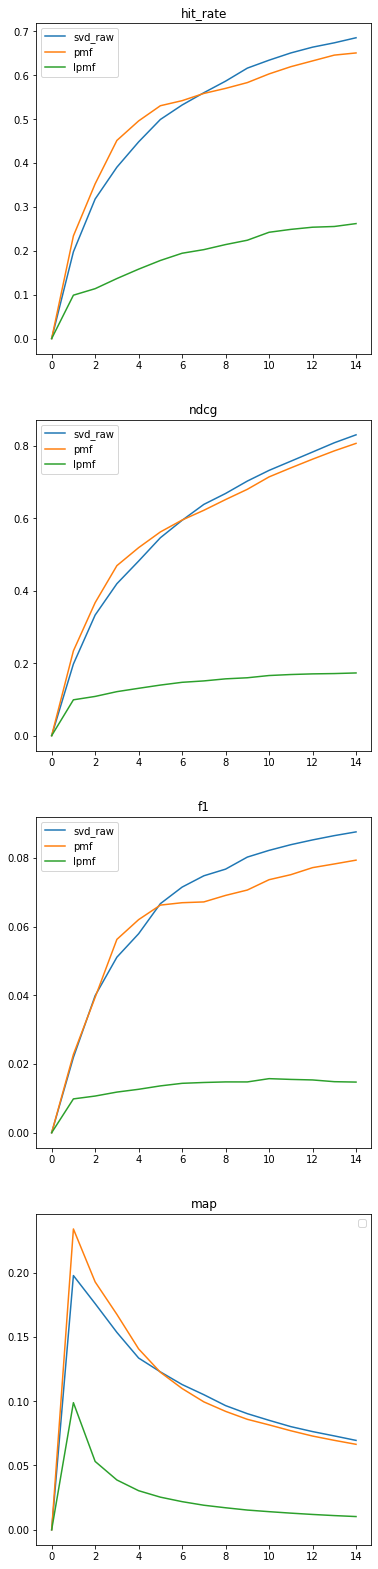

In [14]:
from recom.eval.metrics import hit_rate, ndcg, map, f1
import matplotlib.pyplot as plt

k = 15

metrics = {
    'hit_rate': hit_rate
    , 'ndcg': ndcg
    , 'f1': f1
    , 'map': map
}

preds = {
    'svd_raw': fsvd_pred_results
    , 'pmf': pmf_pred_results
    , 'lpmf': lpmf_pred_results
}

fig, ax = plt.subplots(4, figsize=(6, 28))
for i, m_i in enumerate(metrics.keys()):
    val = [[metrics[m_i](ki, ratings_test_dict, pred) \
            for pred in preds.values()] \
            for ki in range(k)]
    val1, val2, val3 = zip(*val)
    print(val1)
    print(val2)
    print(val3, '\n')
    ax[i].plot(list(range(k)), val)
    ax[i].legend(list(preds.keys()))
    ax[i].set_title(m_i)

plt.legend()
plt.show()